<a href="https://colab.research.google.com/github/EVA6-Group-15/CIFAR_85/blob/master/notebooks/CIFAR10_02_StridedConv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Memory Information

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import psutil
def get_size(bytes, suffix="B"):
    factor = 1024
    for unit in ["", "K", "M", "G", "T", "P"]:
        if bytes < factor:
            return f"{bytes:.2f}{unit}{suffix}"
        bytes /= factor
print("="*40, "Memory Information", "="*40)
svmem = psutil.virtual_memory()
print(f"Total: {get_size(svmem.total)}") ; print(f"Available: {get_size(svmem.available)}")
print(f"Used: {get_size(svmem.used)}") ; print(f"Percentage: {svmem.percent}%")

======================================== Memory Information ========================================
Total: 25.46GB
Available: 24.56GB
Used: 570.97MB
Percentage: 3.5%


In [ ]:
! nvidia-smi

Fri Jun 18 13:43:26 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Module Imports

In [ ]:
!git clone https://github.com/EVA6-Group-15/DLUtils.git ./DLUtils
!cp -r ./DLUtils/src/dlutils/ ./utils
!rm -r DLUtils

In [ ]:
!pip install -U git+https://github.com/albumentations-team/albumentations

In [ ]:
from utils.data.pytorch_data import GetData
from utils.data.transformations import * #HELPER, generate_compose
from utils.visualization import plot_inference, plotter

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary

In [ ]:
use_cuda = torch.cuda.is_available()
DEVICE = torch.device("cuda" if use_cuda else "cpu")

LOADER_kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

In [ ]:
cifar = GetData('CIFAR10')

In [ ]:
train_data = cifar.build_data(train=True)
test_data = cifar.build_data(train=False)


Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified


In [ ]:
loader = DataLoader(
    train_data,
    batch_size=1000,
    num_workers=1,
    shuffle=False
)

mean, std = plotter.data_stats(loader)

Train Statistics
Image Shape:  torch.Size([3, 32, 32])
 - mean: [tensor(0.4914), tensor(0.4822), tensor(0.4465)]
 - std: [tensor(0.2470), tensor(0.2434), tensor(0.2615)]


In [ ]:
trans = generate_compose(mean, std) #Normalize and ToTensor by Default

In [ ]:
train_data = cifar.build_data(trans, train=True)
test_data = cifar.build_data(trans, train=False)
train_loader = cifar.build_loader(train_data, 64, **LOADER_kwargs)
test_loader = cifar.build_loader(test_data, 64, **LOADER_kwargs)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
classes = train_data.classes
print(classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


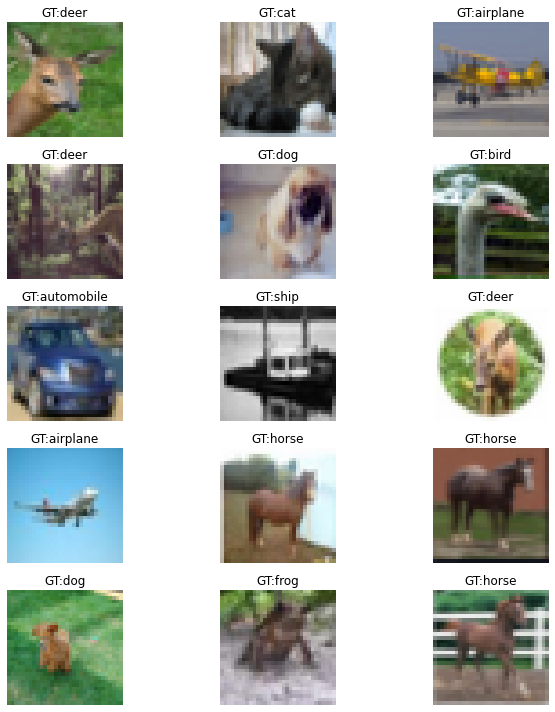

In [ ]:
from utils.visualization import plot_inference, plotter
plotter.plot_data_grid(train_loader, mean= mean, std= std, class_list=classes, ncol=3,nrow=5)

# Model

In [ ]:
from utils.models.CIFAR10.model_OnlyStrided import Net

In [ ]:
model = Net().to(DEVICE)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]           4,608
       BatchNorm2d-5           [-1, 32, 32, 32]              64
              ReLU-6           [-1, 32, 32, 32]               0
            Conv2d-7           [-1, 32, 15, 15]           9,216
       BatchNorm2d-8           [-1, 32, 15, 15]              64
              ReLU-9           [-1, 32, 15, 15]               0
           Conv2d-10           [-1, 16, 15, 15]             512
      BatchNorm2d-11           [-1, 16, 15, 15]              32
             ReLU-12           [-1, 16, 15, 15]               0
           Conv2d-13           [-1, 32, 15, 15]           4,608
      BatchNorm2d-14           [-1, 32,

In [ ]:
from utils.features.runner import run

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
ai = run.Run(model, train_loader, test_loader, 50, DEVICE, optimizer)
ai()

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 1


loss=0.9012464880943298 batch_id=781: 100%|██████████| 782/782 [00:12<00:00, 62.19it/s]


TRAIN set: Average loss: 1.6242, Train Accuracy: 38.35% | TEST set: Average loss: 1.3052, Test Accuracy: 52.26%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 2
TRAIN set: Average loss: 1.1405, Train Accuracy: 58.41% | TEST set: Average loss: 1.0806, Test Accuracy: 60.48%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 3
TRAIN set: Average loss: 0.9315, Train Accuracy: 66.41% | TEST set: Average loss: 0.9817, Test Accuracy: 65.39%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 4
TRAIN set: Average loss: 0.8027, Train Accuracy: 71.59% | TEST set: Average loss: 0.9014, Test Accuracy: 68.45%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 5
TRAIN set: Average loss: 0.7102, Train Accuracy: 75.18% | TEST set: Average loss: 0.7904, Test Accuracy: 72.65%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 6
TRAIN set: Average loss: 0.6420, Train Accuracy: 77.37% | TEST set: Average loss: 0.7691, Test Accur

In [ ]:
print('Train Accuracy:', max(ai.metrics['train_accuracy']))
print('Test Accuracy:', max(ai.metrics['test_accuracy']))

Train Accuracy: 98.666
Test Accuracy: 78.18


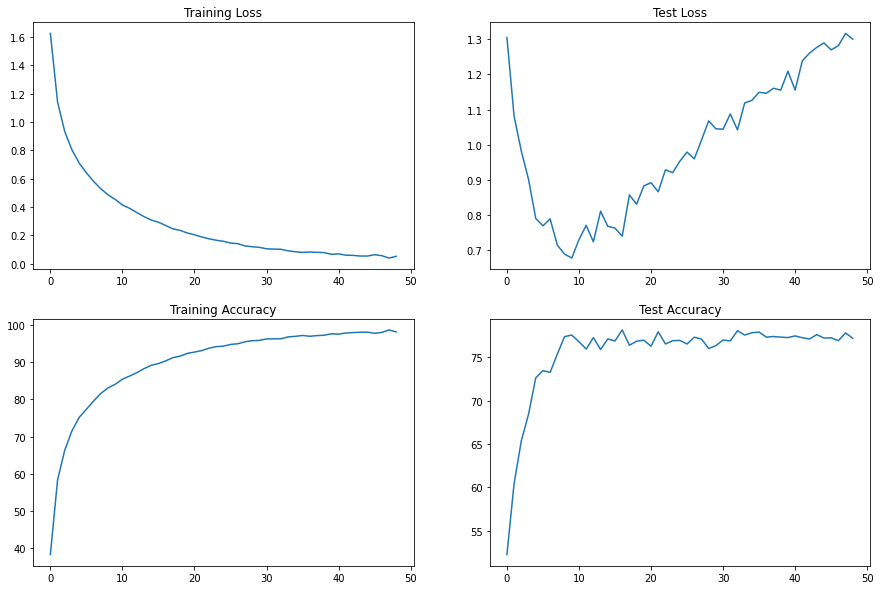

In [ ]:
plotter.plot_loss_acc(ai.metrics['train_loss'], ai.metrics['train_accuracy'], ai.metrics['test_loss'], ai.metrics['test_accuracy'])

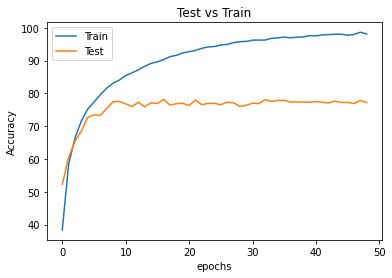

In [ ]:
plotter.plot_combined([ai.metrics['train_accuracy'], ai.metrics['test_accuracy']])

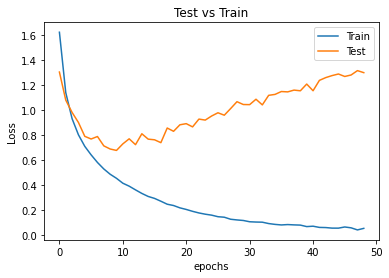

In [ ]:
plotter.plot_combined([ai.metrics['train_loss'], ai.metrics['test_loss']], y_label='Loss')

In [ ]:
results = plot_inference.Results(model, test_loader, DEVICE, mean, std, classes)

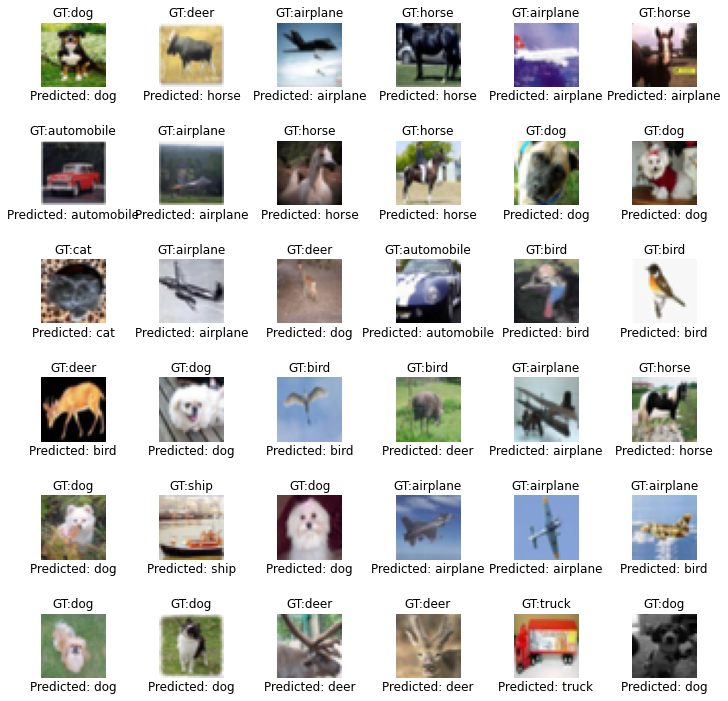

In [ ]:
results.plot_batch(6,6)

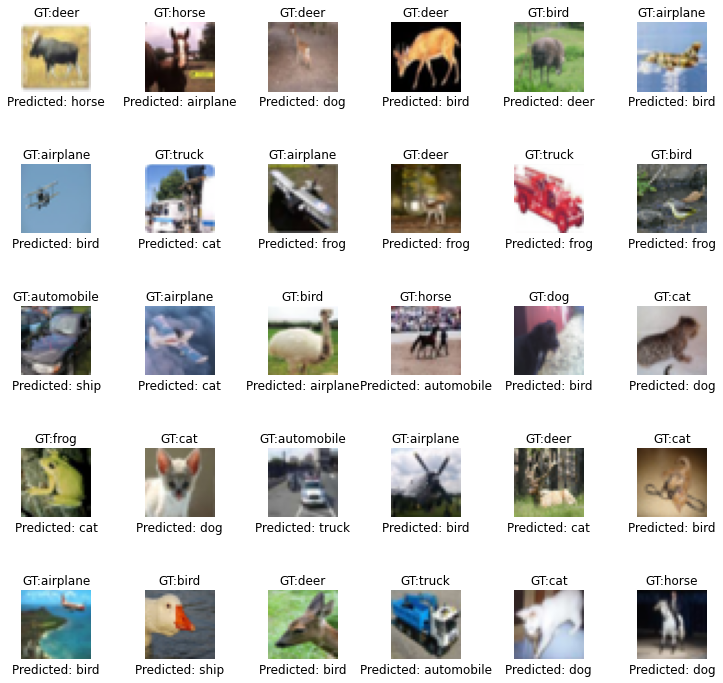

In [ ]:
results.plot_incorrect(5,6)

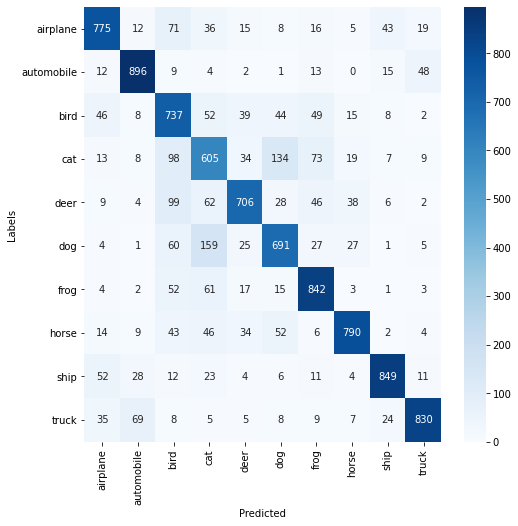

Accuracies of Top 10 Classes in Decreasing Order
Accuracy of class cat is 60.50
Accuracy of class dog is 69.10
Accuracy of class deer is 70.60
Accuracy of class bird is 73.70
Accuracy of class airplane is 77.50
Accuracy of class horse is 79.00
Accuracy of class truck is 83.00
Accuracy of class frog is 84.20
Accuracy of class ship is 84.90
Accuracy of class automobile is 89.60


In [ ]:
results.class_accuracy()